In [ ]:
#| hide
import matplotlib.pylab as plt
import numpy as np
import matplotlib as mpl
from scipy import stats

# HydroColors

> Painting HACC Hydrodynamical simulations using Spectral Population Synthesis

## Installation

```sh
pip install hydro_colors
```

## Simple implementation to HACC hydro data

#### 1. First we import the following modules of hydro_colors 

In [ ]:
import hydro_colors as hc
from hydro_colors.load_sim_stellar_catalog import load_hacc_galaxy_data
from hydro_colors.calculate_csp import calc_fluxes_for_galaxy
from hydro_colors.load_sps_library import STELLAR_LIBRARY_DIR

#### 2. Then the galaxy-star catalog from HACC is loaded

In [ ]:
galaxy_star_catalog_file = '../hydro_colors/data/test_hacc_stellar_catalog/Gals_Z0_576.txt'
galaxy_tags, stellar_idx, _, _, _, x, y, z, _, _, _ = hc.load_sim_stellar_catalog.load_hacc_galaxy_data(galaxy_star_catalog_file)

#### 3. After selecting a unique galaxy tag, we calculate the SED. This is the rest-frame SED is due to spectral emission alone, and without dust attenuation.  

In [ ]:
galaxy_number = 4
unique_galaxy_tag = np.unique(galaxy_tags)[galaxy_number]
print('Number of galaxies: %d'%np.unique(galaxy_tags).shape[0])

spec_wave_ssp, spec_flux_ssp, spec_csp, flux_proxy, gal_stellar_mass = hc.calculate_csp.calc_fluxes_for_galaxy(galaxy_star_catalog_file,
                                                                                                               unique_galaxy_tag,
                                                                                                               STELLAR_LIBRARY_DIR)

Number of galaxies: 10
Library shape:  (22, 94, 1963)
Wavelength shape:  (1963,)


#### 4. Finally, we plot SEDs from both SSPs and CSPs

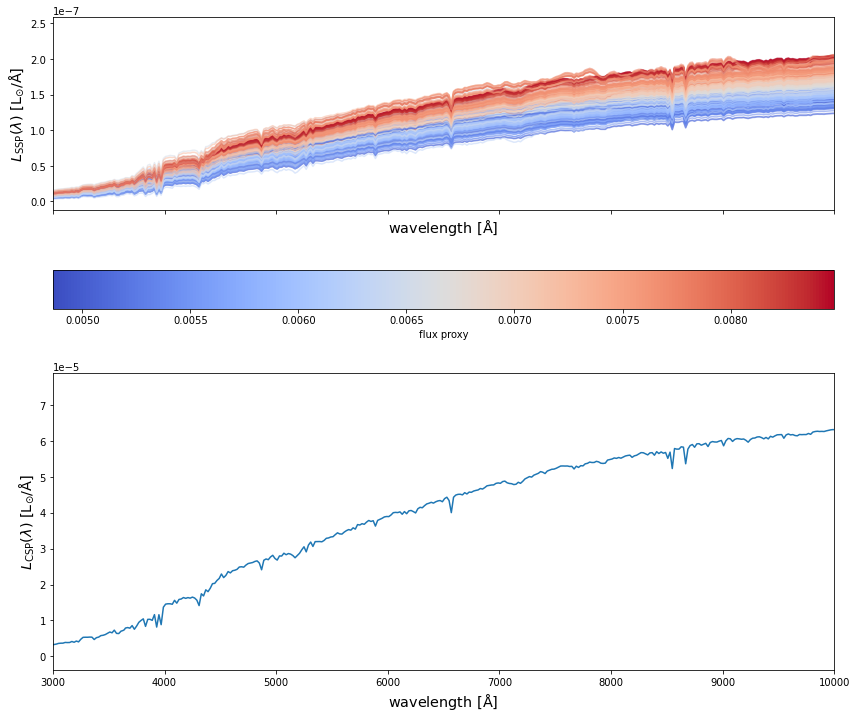

In [ ]:
fig, a = plt.subplots(2,1, figsize=(14, 12), sharex=True, sharey=False)
c_norm = mpl.colors.Normalize(vmin=np.min(flux_proxy), vmax=np.max(flux_proxy))
c_map  = mpl.cm.coolwarm

s_map  = mpl.cm.ScalarMappable(cmap=c_map, norm=c_norm)
s_map.set_array([])


for idx in range(spec_flux_ssp.shape[0]):
    
    # spec_flux_ssp[idx] = spec_ssp(age_hydro[ssp_id], metal_hydro[ssp_id], mass[ssp_id])
    a[0].plot(spec_wave_ssp, spec_flux_ssp[idx], 
              # color=s_map.to_rgba(np.log10(mass[ssp_id])), 
              color=s_map.to_rgba(flux_proxy[idx]), 
              alpha=0.5)

fig.colorbar(s_map, ax = a[0], 
             orientation = 'horizontal', 
             # label=r'stellar mass', pad=0.2)
             label=r'flux proxy', pad=0.2)
    

#####################################################################

a[1].plot(spec_wave_ssp, spec_csp)


# a[0].set_ylim(1e-9, 1e-6)
# a[0].set_yscale('log')
# a[1].set_yscale('log')
# a[1].set_xscale('log')
a[1].set_xlim(3e3, 1e4)


a[0].set_xlabel(r'${\rm wavelength\ [\AA]}$', fontsize = 'x-large')
a[1].set_xlabel(r'${\rm wavelength\ [\AA]}$', fontsize = 'x-large')
a[0].set_ylabel(r'$L_{\rm SSP}(\lambda)\ {\rm [L_{\odot}/\AA]}$', fontsize = 'x-large')
a[1].set_ylabel(r'$L_{\rm CSP}(\lambda)\ {\rm [L_{\odot}/\AA]}$', fontsize = 'x-large')


plt.show()

### One can also find luminosity profiles for the simulated galaxies

#### 1. First we project the luminosity on to grids

In [ ]:
#| hide 

# xedges = np.linspace(x[gal_tag_cond].min(), x[gal_tag_cond].max(), nbins) 
# yedges = np.linspace(y[gal_tag_cond].min(), y[gal_tag_cond].max(), nbins) 

# # H, xedges, yedges = np.histogram2d(x[gal_tag_cond], y[gal_tag_cond], bins=(xedges, yedges))


# H, xedges, yedges, binnumber = stats.binned_statistic_2d(x[gal_tag_cond], y[gal_tag_cond], 
#                                                          None, 'count', bins=[xedges, yedges],
#                                                          expand_binnumbers=True)


In [ ]:
gal_tag_cond = np.where(galaxy_tags == unique_galaxy_tag)

# x_centered_scaled =  (x[gal_tag_cond] - np.min(x[gal_tag_cond]))/(np.max(x[gal_tag_cond]) - np.min(x[gal_tag_cond]))
# y_centered_scaled =  (y[gal_tag_cond] - np.min(y[gal_tag_cond]))/(np.max(y[gal_tag_cond]) - np.min(y[gal_tag_cond]))

x_centered_scaled =  (x[gal_tag_cond] - np.mean(x[gal_tag_cond]))/(np.max(x[gal_tag_cond]) - np.min(x[gal_tag_cond]))
y_centered_scaled =  (y[gal_tag_cond] - np.mean(y[gal_tag_cond]))/(np.max(y[gal_tag_cond]) - np.min(y[gal_tag_cond]))

nbins = 60


xedges = np.linspace(x_centered_scaled.min(), x_centered_scaled.max(), nbins) 
yedges = np.linspace(y_centered_scaled.min(), y_centered_scaled.max(), nbins) 


H, xedges, yedges, binnumber = stats.binned_statistic_2d(x_centered_scaled, y_centered_scaled, 
                                                         None, 'count', bins=[xedges, yedges],
                                                         expand_binnumbers=True)


grid_flux = np.zeros_like(H)

for idx, ssp_id in enumerate(gal_tag_cond[0]):
    grid_flux[binnumber[:, idx][0]-1, binnumber[:, idx][1]-1] = np.trapz(spec_flux_ssp[idx], spec_wave_ssp)

#### 2. Next we plot the stellar density and luminosity profiles

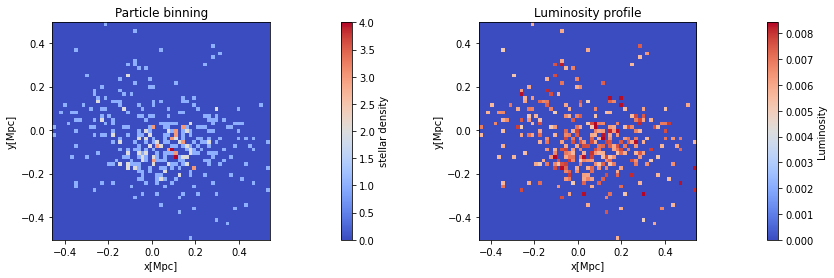

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
c_norm = mpl.colors.Normalize(vmin=1, vmax=np.max(H))
c_map  = mpl.cm.coolwarm


ax[0].set_title('Particle binning')

im = ax[0].imshow(H, interpolation='nearest', origin='lower', 
                extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], 
                cmap=c_map)

fig.colorbar(im, ax = ax[0], 
             orientation = 'vertical', 
             # label=r'stellar mass', pad=0.2)
             label=r'stellar density', pad=0.2)


# Normalize the array vals so they can be mapped to a color
c_norm = mpl.colors.Normalize(vmin=np.min(grid_flux.min()), vmax=np.max(grid_flux))
c_norm = mpl.colors.Normalize(vmin=0.004, vmax=np.max(grid_flux))

# # Pick a colormap
# c_map  = mpl.cm.magma


ax[1].set_title('Luminosity profile')
im = ax[1].imshow(grid_flux, interpolation='nearest', origin='lower', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], cmap=c_map)

# Adding the colorbar
fig.colorbar(im, ax = ax[1], 
             orientation = 'vertical', 
             # label=r'stellar mass', pad=0.2)
             label=r'Luminosity', pad=0.2)


ax[0].set_xlabel('x[Mpc]')
ax[0].set_ylabel('y[Mpc]')
ax[1].set_xlabel('x[Mpc]')
ax[1].set_ylabel('y[Mpc]')

ax[0].set_aspect('equal', adjustable='box')
ax[1].set_aspect('equal', adjustable='box')


plt.show()

### Radial mass profile of the galaxy

/tmp/ipykernel_2275932/3123066502.py:45: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pc2 = ax0.pcolormesh(A2, R2, np.repeat(hist.T, subdivs, axis=1), cmap='gist_heat_r')
/tmp/ipykernel_2275932/3123066502.py:58: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pc3 = ax2.pcolormesh(A2, R2, np.repeat(grid_flux_polar.T, subdivs, axis=1), cmap='gist_heat_r')


Text(0, 0.5, 'Luminosity')

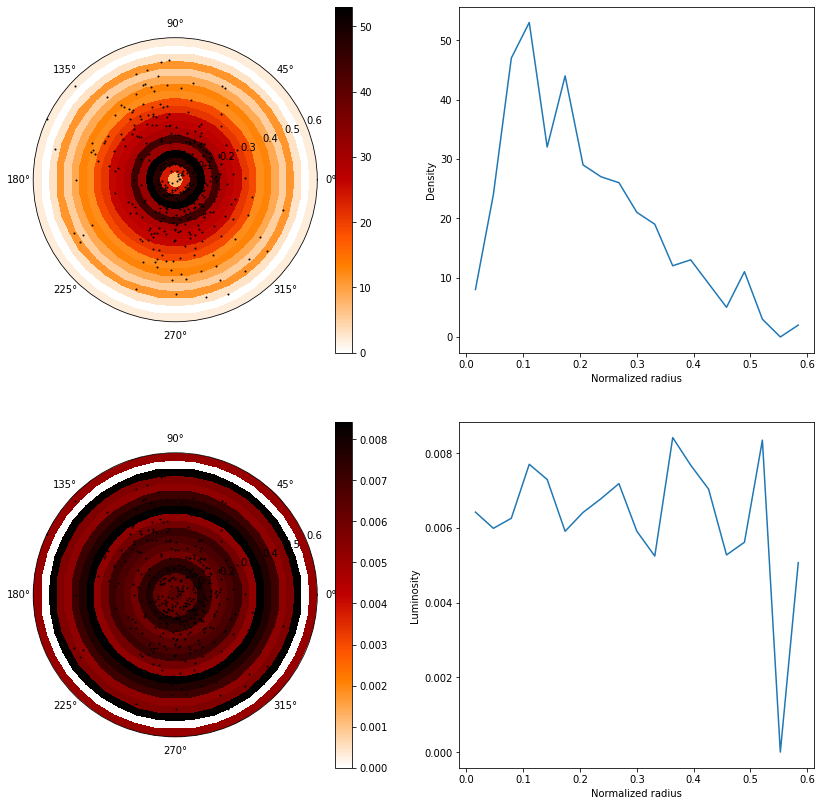

In [ ]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

radius, azimut = cart2pol(x_centered_scaled, y_centered_scaled)
azimut += np.pi

# define binning
rbins = np.linspace(0,radius.max(), 20)
abins = np.linspace(0,2*np.pi, 2)


subdivs = 40
abins2 = np.linspace(0, 2 * np.pi, (len(abins) - 1) * subdivs + 1)



#calculate histogram for mass density
# hist, _, _ = np.histogram2d(azimut, radius, bins=(abins, rbins))
hist, _, _, binnumbers = stats.binned_statistic_2d(azimut, radius, 
                                                         None, 'count', bins=[abins, rbins],
                                                         expand_binnumbers=True)


# Luminosity
grid_flux_polar = np.zeros_like(hist)

for idx, ssp_id in enumerate(gal_tag_cond[0]):
    grid_flux_polar[binnumbers[:, idx][0]-1, binnumbers[:, idx][1]-1] = np.trapz(spec_flux_ssp[idx], spec_wave_ssp)
    
    
    

A, R = np.meshgrid(abins, rbins)
A2, R2 = np.meshgrid(abins2, rbins)

# plot

fig = plt.figure(figsize=(14 , 14))
ax0 = plt.subplot(221, projection="polar")
ax1 = plt.subplot(222)

# pc = ax.pcolormesh(A, R, hist.T, cmap="magma_r")
pc2 = ax0.pcolormesh(A2, R2, np.repeat(hist.T, subdivs, axis=1), cmap='gist_heat_r')
pc3 = ax0.scatter(azimut, radius, alpha=1, marker='o', s=1, color='k')
fig.colorbar(pc2, ax=ax0)

ax1.plot(0.5*(rbins[1:] + rbins[:-1]), np.sum(hist, axis=0));
ax1.set_xlabel('Normalized radius')
ax1.set_ylabel('Density')


ax2 = plt.subplot(223, projection="polar")
ax3 = plt.subplot(224)

# pc = ax.pcolormesh(A, R, hist.T, cmap="magma_r")
pc3 = ax2.pcolormesh(A2, R2, np.repeat(grid_flux_polar.T, subdivs, axis=1), cmap='gist_heat_r')
pc4 = ax2.scatter(azimut, radius, alpha=1, marker='o', s=1, color='k')
fig.colorbar(pc3, ax=ax2)

ax3.plot(0.5*(rbins[1:] + rbins[:-1]), np.sum(grid_flux_polar, axis=0));
ax3.set_xlabel('Normalized radius')
ax3.set_ylabel('Luminosity')


In [ ]:
#| hide 

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [ ]:
#| hide 

def radial_profile(data):
    y, x = np.indices((data.shape)) # first determine radii of all pixels
    
    # x = xedges[0] + ((x - np.min(x))*(xedges[1] - xedges[0])/(np.max(x) - np.min(x)))
    # y = yedges[0] + ((y - np.min(y))*(yedges[1] - yedges[0])/(np.max(y) - np.min(y)))
    
    center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])
    r = np.sqrt((x-center[0])**2+(y-center[1])**2)    

    # radius of the image.
    r_max = np.max(r) 
    print(r.min(), r.max())

    ring_brightness, radius = np.histogram(r, weights=data, bins= np.int32(r_max/2))
    # ring_brightness, radius = np.histogram(r, weights=data, bins= 10)
    
    
    x2_prime = ((x-center[0])*(xedges[1] - xedges[0])/(x.max()-x.min()))**2
    y2_prime = ((y-center[1])*(yedges[1] - yedges[0])/(y.max()-y.min()))**2
    
    r_prime = np.sqrt(x2_prime + y2_prime)

    plt.plot(radius[1:], ring_brightness)
    # plt.xlim(np.min(r), np.max(r))
    plt.show()

0.0 41.012193308819754


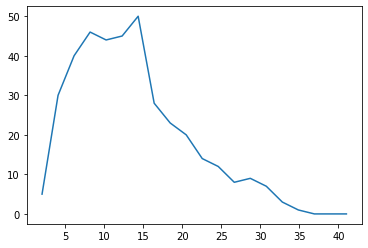

0.0 41.012193308819754


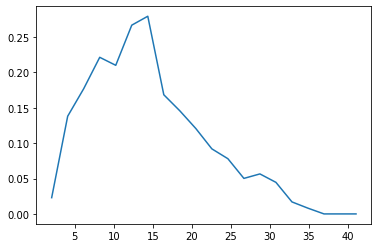

In [ ]:
#| hide 

radial_profile(H)

radial_profile(grid_flux)

Text(0, 0.5, 'Luminosity profile')

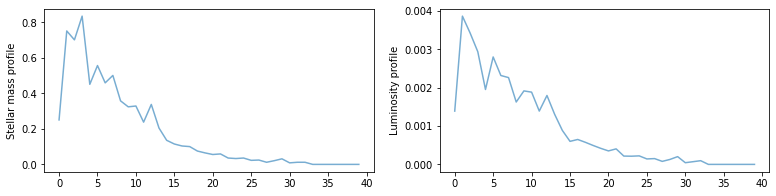

In [ ]:
#| hide 

fig, ax = plt.subplots(1, 2, figsize=(13, 3))

ax[0].plot(azimuthalAverage(H), '-', alpha=0.6)
ax[1].plot(azimuthalAverage(grid_flux), '-', alpha=0.6)

ax[0].set_ylabel('Stellar mass profile')
ax[1].set_ylabel('Luminosity profile')

## Under the hood

In [ ]:
from hydro_colors.load_sps_library import *
from hydro_colors.load_sim_stellar_catalog import *

Library shape:  (22, 94, 1963)
Wavelength shape:  (1963,)


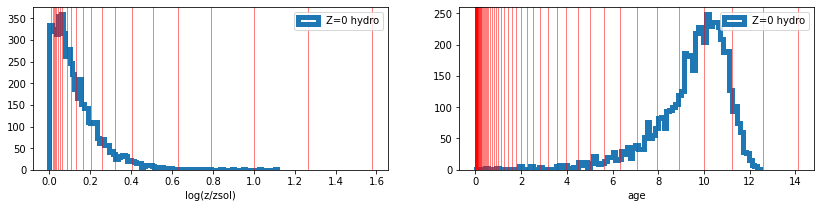

In [ ]:
spec_flux, spec_wave = load_fsps_spectral_library()
age_fsps_gyr, Z_padova_fsps = load_fsps_age_metallicity()
gal_tag, stellar_idx, metal_hydro, mass, age_hydro, x, y, z, vx, vy, vz = load_hacc_galaxy_data()


f, a = plt.subplots(1,2, figsize=(14, 3))
a[0].hist(metal_hydro, bins = 100, histtype='step', lw=5, label='Z=0 hydro');
[a[0].axvline(_x, linewidth=1, color='r', alpha=0.5) for _x in Z_padova_fsps];
a[0].legend()
a[0].set_xlabel('log(z/zsol)')


a[1].hist(age_hydro, bins = 100, histtype='step', lw=5, label='Z=0 hydro');
[a[1].axvline(_x, linewidth=1, color='r', alpha=0.5) for _x in age_fsps_gyr];
a[1].legend()
a[1].set_xlabel('age')

plt.show()